# Steam Data Exploration: Profitable App Profiles

*This forms part of a larger series of posts for my [blog](http://nik-davis.github.io) on downloading, processing and analysing data from the steam store. [See all posts here](http://nik-davis.github.io/tag/steam).*

In [1]:
# view software version information

# http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
# %reload_ext version_information

%version_information numpy, pandas, matplotlib, seaborn, sklearn

Software versions
Python 3.7.3 64bit [MSC v.1900 64 bit (AMD64)]
IPython 7.5.0
OS Windows 10 10.0.18362 SP0
numpy 1.16.3
pandas 0.24.2
matplotlib 3.1.0
seaborn 0.9.0
sklearn 0.21.2
Wed Jul 03 15:02:54 2019 GMT Summer Time

In [2]:
# from IPython.display import HTML
# HTML('''
# <script>
#   function code_toggle() {
#     if (code_shown){
#       $('div.input').hide('500');
#       $('#toggleButton').val('Show Code')
#     } else {
#       $('div.input').show('500');
#       $('#toggleButton').val('Hide Code')
#     }
#     code_shown = !code_shown
#   }

#   $( document ).ready(function(){
#     code_shown=false;
#     $('div.input').hide()
#   });
# </script>
# <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

## Ideas
- when will valve release half life 3
- best publishers/developers (or best and worst releases)
- older is better/ best year for games
- Is single-player dying? single vs multiplayer
- description columns - analyse sentiment/emotion

### Issues
- prediction - low correlations so difficult

In [11]:
# standard library imports
from ast import literal_eval
import itertools
import time
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_selection import RFECV

# customisations
pd.set_option("max_columns", 100)
plt.style.use('default') # same as plt.rcdefaults(), default matplotlib style
# sns.set() # default seaborn style

## Import data and preprocess for exploration

In [12]:
def remove_non_english(df):
    df = df[df['english'] == 1].copy()
    
    # doesn't contain 3 or more non-ascii characters
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    df = df.drop('english', axis=1)
    
    return df


def calc_rating(row):

    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg

    average = pos / total_reviews

    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100


def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))


def process_cat_gen_tag(df):
    cat_cols = get_unique(df['categories'])
    
    cat_cols = [
#         'Local Multi-Player',
#         'MMO',
#         'Mods',
        'Multi-player',
#         'Online Co-op',
#         'Online Multi-Player',
        'Single-player'
    ]
    
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    gen_cols = get_unique(df['genres'])
    
    gen_cols = [
#         'Accounting',
        'Action',
        'Adventure',
#         'Animation & Modeling',
#         'Audio Production',
        'Casual',
#         'Design & Illustration',
#         'Documentary',
#         'Early Access',
#         'Education',
#         'Free to Play',
#         'Game Development',
#         'Gore',
        'Indie',
        'Massively Multiplayer',
#         'Nudity',
#         'Photo Editing',
        'RPG',
        'Racing',
#         'Sexual Content',
        'Simulation',
#         'Software Training',
        'Sports',
        'Strategy'
#         'Tutorial',
#         'Utilities',
#         'Video Production',
#         'Violent',
#         'Web Publishing'
    ]
    
    gen_col_names = []
    
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    # remove "non-games" based on genre
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
        
    # tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])
    
    # display(cat_cols, gen_cols, tag_cols)
    # df = df.drop(['categories', 'genres', 'steamspy_tags'], axis=1)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df


def process_year(df):
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    return df


def process_dev_pub(df):
    for col in ['developer', 'publisher']:
        col_name = col+'_rating'
        ratings = df.groupby(col).mean()['rating']
        df[col_name] = df[col].apply(lambda x: ratings[x] if x in ratings else 0)
        
        release_counts =  df.groupby(col).count()['steam_appid']
        df[col+'_releases'] = df[col].apply(lambda x: release_counts[x] if x in release_counts else 0)
        
    return df
    
def process_revenue(df):
    df['est_revenue'] = df['owners'] * df['price']
    return df


def process_price(df):
    cut_points = [-1, 0, 4, 10, 30, 50, 1000]
    label_names = ['free', 'very cheap', 'cheap', 'moderate', 'expensive', 'very expensive']
    
    df['price_categories'] = pd.cut(df['price'], cut_points, labels=label_names)
    
    return df


def pre_process():
    df = pd.read_csv('../data/steam_clean.csv')
    
    # english only
    df = remove_non_english(df)
    
    # windows only
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int) #.apply(lambda x: (int(x[0]) + int(x[1])) / 2).astype(int)
    # df['owners'] = df['owners'].str.replace('[+,]', '').astype(int)
    
    # calculate ratings
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    # df = df.drop(['positive', 'negative'], axis=1)
    
    
    df = process_year(df)
    # df = process_dev_pub(df)

    # df = process_revenue(df)
    # df = process_price(df)
    
    df = process_cat_gen_tag(df)
    
    return df

data = pre_process()

print(data.isnull().sum().value_counts())
data.head()

0    30
dtype: int64


,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,rating_ratio,rating,release_year,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,Action,0,124534,3339,17612,317,10000000,7.19,127873,0.973888,95.975678,2000,1,0,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,Action,0,3318,633,277,62,5000000,3.99,3951,0.839787,80.508259,1999,1,0,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,Action,0,3416,398,187,34,5000000,3.99,3814,0.895648,85.823915,2003,1,0,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,Action,0,1273,267,258,184,5000000,3.99,1540,0.826623,78.126542,2001,1,0,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,Action,0,5250,288,624,415,5000000,3.99,5538,0.947996,91.260480,1999,1,1,1,0,0,0,0,0,0,0,0,0


# Data Overview

- focus on genres, owners, price, year, ratings

Take a look at KDE and scatter plots to gain some intuition about relationships between features:


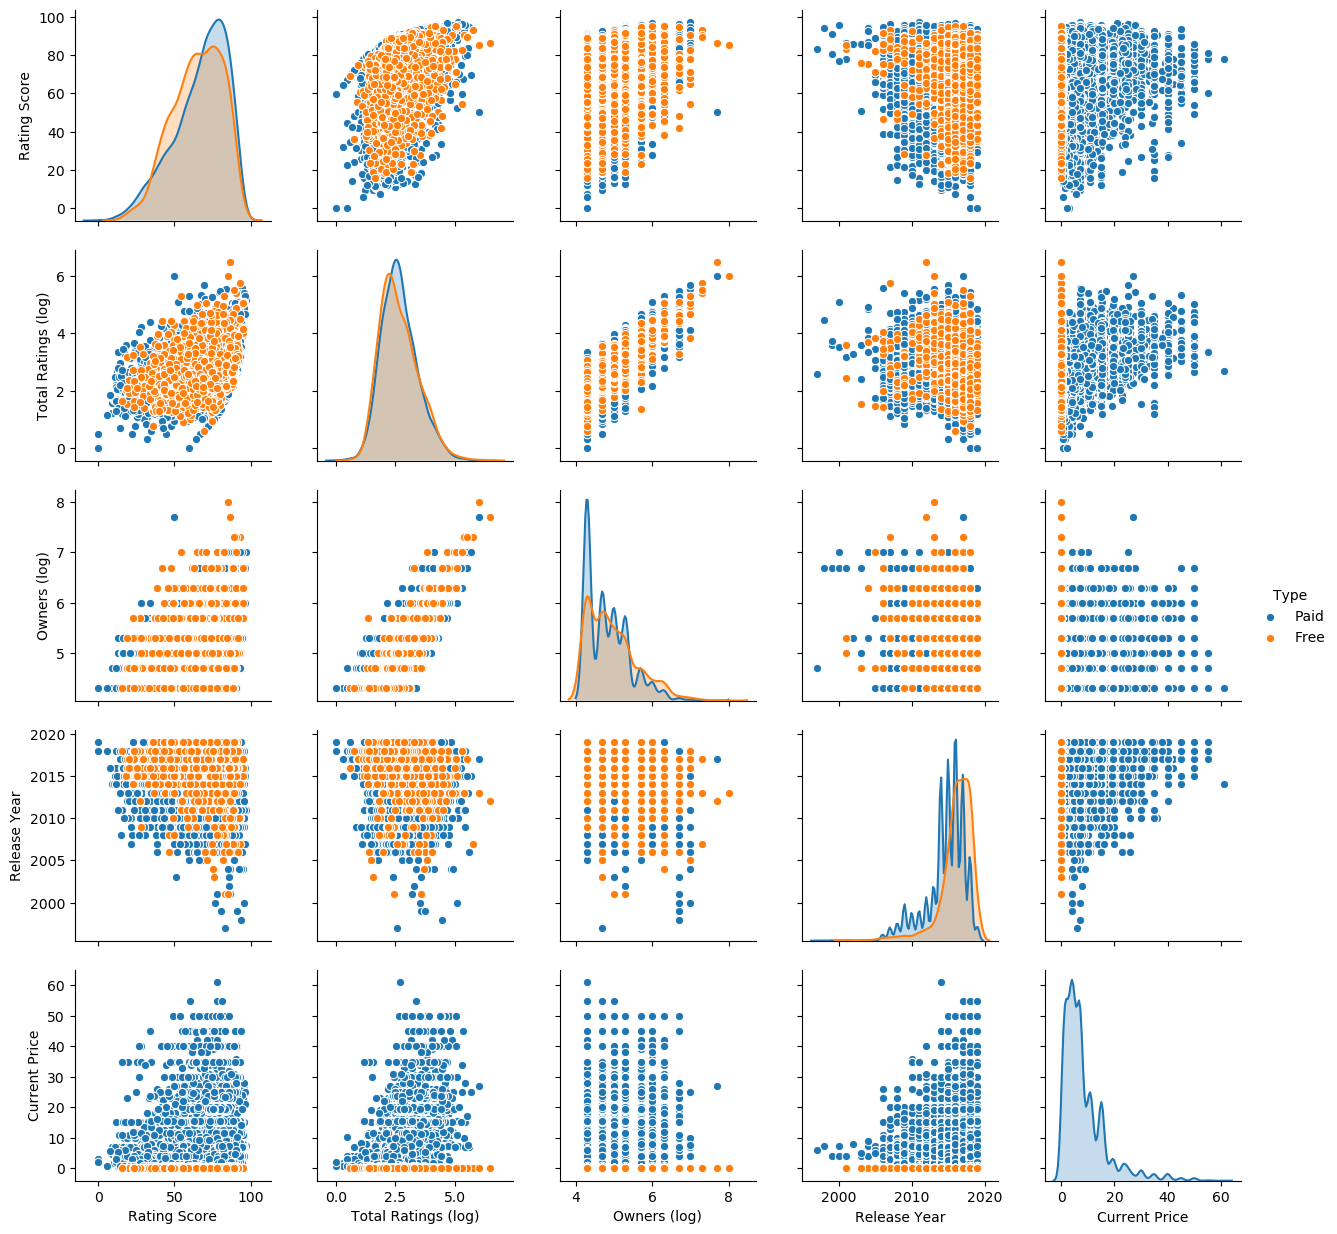

In [13]:
import warnings
warnings.filterwarnings('ignore')

data['type'] = 'Free'
data.loc[data['price'] > 0, 'type'] = 'Paid'

df = data[data['owners'] > 0].copy()

eda_df = pd.DataFrame(zip(df['rating'],
                          np.log10(df['total_ratings']),
                          np.log10(df['owners']),
                          df['release_year'],
                          df.price,#df[df.price>0]['price'],
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price', 'Type'])

sns.pairplot(eda_df, hue='Type');

warnings.filterwarnings('default')

Observations:
- Higher ratings on average for paid games
- Ratings for free games slightly more spread out

- Looks like more owners for paid games, but unclear
- Slightly more ratings given to Paid games than free

- The more owners, the more ratings
- The more owners, the higher the average rating appears to be, suggesting the better rated a game, the more people buy it

- Shift towards more Free games in recent years
- More recent games are more expensive

- Large proportion of games priced between £0 and £20, with most between £0 and £10

Trends to investigate:
- Ratings decrease over time, especially for free games
- As price increases, rating increases, suggesting people may be more likely to rate a game higher if they spent more on it? ALso, the more expensive, the more ratings it has, suggesting the more people pay the more likely they are to leave a review.

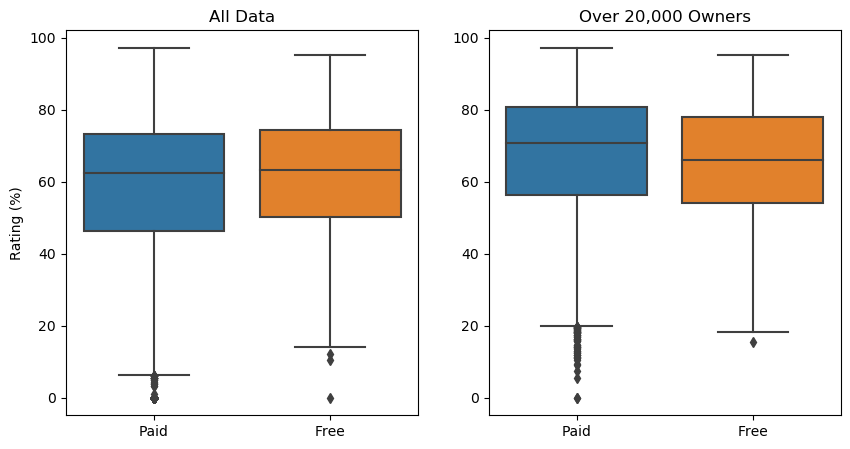

In [14]:
fig, axarr = plt.subplots(1, 2, figsize=(10,5))

df = data.copy()
# df.boxplot(by='type', column='rating', ax=axarr[0])
sns.boxplot(x='type', y='rating', data=df, ax=axarr[0])
axarr[0].set_title('All Data')
axarr[0].set_ylabel('Rating (%)')
axarr[0].set_xlabel('')

df = data[data.owners > 0].copy()
# df.boxplot(by='type', column='rating', ax=axarr[1])
sns.boxplot(x='type', y='rating', data=df, ax=axarr[1])
axarr[1].set_title('Over 20,000 Owners')
axarr[1].set_ylabel('')
axarr[1].set_xlabel('')

plt.show()

- If look at games with over 20,000 owners, paid games receive higher ratings on average. However, if we include the games with less than 20,000 owners, paid games receive very slightly worse ratings on average. Clearly these games have a large impact on average ratings for some reason.
- For analysis, which should we choose to include? Let's take a closer look

In [15]:
print(f'Games with fewer than 20,000 owners: {data[data.owners < 20000].shape[0]}\n',
      f'Games with more than 20,000 owners: {data[data.owners >= 20000].shape[0]}')

Games with fewer than 20,000 owners: 17721
 Games with more than 20,000 owners: 8230


Taking a look at the amounts, over two thirds of games in the dataset have fewer than 20,000 owners. That's the vast majority of the dataset, and these games will have a huge impact on any analysis we make, so including them or not is a very important decision.

No right answer, but have to keep consequences in mind.

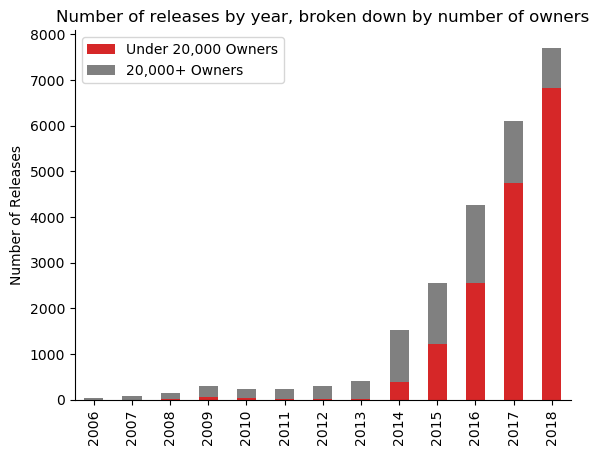

In [16]:
df = data.copy()

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        continue
    year_df = df[df.release_year == year]
    
    total_lt_20k = year_df[year_df.owners < 20000].shape[0]
    total_gt_20k = year_df[year_df.owners >= 20000].shape[0]
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'gray'])#, figsize=(12,8))#['gray', 'red'])
ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by number of owners')
sns.despine()
plt.show()

Looking at the chart above, 
- Since 2014, the number of releases for games having 20,000 or more owners has remained relatively constant, seen by the size of the gray bar for each year. 
- The number of releases with fewer than 20,000 owners skyrocketed in this same period. A couple of likely reasons: greenlight/direct. My interpretation is that the store has been somewhat flooded with low-quality releases, suggesting the vast majority can be ignored. 

To get useful information therefore, we will focus on games with 20,000+ owners only

Greenlight opened Aug 2012: https://store.steampowered.com/news/8761/  
Greenlight closed, Steam Direct opened Jun 2017: https://steamcommunity.com/games/593110/announcements/detail/1328973169870947116

## Release Year

We'll combine what we've just been looking at, and investigate how ratings have changed from year to year.

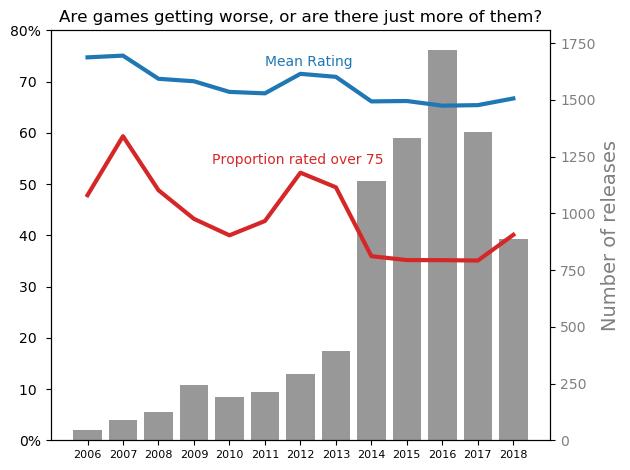

In [17]:
df = data[data.owners >= 20000].copy()

rating_threshold = 75

years = []
proportions = []
totals = []
avg_ratings = []
max_ratings = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        continue
    
    year_data = df[df['release_year'] == year]
    total = year_data.shape[0]
    n_high_rating = year_data[year_data['rating'] >= rating_threshold].shape[0]
    avg_rating = year_data['rating'].mean() / 100
    
    years.append(year)
    proportions.append(n_high_rating/total)
    avg_ratings.append(avg_rating)
    totals.append(total)
    
    # print(f'{year} | {n_high_rating/total:.2f}')
    
plt.rcdefaults()
fig, ax1 = plt.subplots()

ax1.set_zorder(1)
ax1.patch.set_visible(False)

x_pos = np.arange(len(years))

ax1.plot(avg_ratings, color='tab:blue', label='Average Rating', linewidth=3)
ax1.plot(proportions, color='tab:red', label=f'Proportion of games rated over {rating_threshold}', linewidth=3)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(years, fontsize=8)
ax1.set_yticks(np.arange(0, 0.9, 0.1))
ax1.set_yticklabels(['0%', '10 ', '20 ', '30 ', '40 ', '50 ', '60 ', '70 ', '80%'])

ax1.text(5, 0.73, 'Mean Rating', color='tab:blue')
ax1.text(3.5, 0.54, 'Proportion rated over 75', color='tab:red')

# ax1.legend(loc='center', bbox_to_anchor=(0.5, 1.1))

ax2 = ax1.twinx()

color = 'tab:gray'
ax2.bar(x_pos, totals, color=color, alpha=.8)
ax2.set_ylabel('Number of releases', color=color, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_title('Are games getting worse, or are there just more of them?')
fig.tight_layout()
plt.show()

Are games getting worse?

- Average rating, year on year, has fallen for the most part. 
- Peak between 2012 and 2013. Over half the games released in those years scored 75 or higher.
- As we saw, big increase from 2014, which appears to drag down the average. If we ignore the 2012/2013 peak however, there is very little change.

 # Data Overview/Genres
 - Take a look at the top rated games

,name,developer,publisher,release_year,genres,average_playtime,owners,rating,price
23,Portal 2,Valve,Valve,2011,Action;Adventure,1102,10000000,97.257760,7.19
7577,Factorio,Wube Software LTD.,Wube Software LTD.,2016,Casual;Indie;Simulation;Strategy;Early Access,10087,1000000,96.601391,21.00
2964,The Witcher® 3: Wild Hunt,CD PROJEKT RED,CD PROJEKT RED,2015,RPG,3068,5000000,96.465364,24.99
17,Portal,Valve,Valve,2007,Action,288,10000000,96.103502,7.19
0,Counter-Strike,Valve,Valve,2000,Action,17612,10000000,95.975678,7.19
1120,Terraria,Re-Logic,Re-Logic,2011,Action;Adventure;Indie;RPG,5585,5000000,95.907030,6.99
1962,The Binding of Isaac: Rebirth,"Nicalis, Inc.","Nicalis, Inc.",2014,Action,4583,2000000,95.871763,10.99
3036,RimWorld,Ludeon Studios,Ludeon Studios,2018,Indie;Simulation;Strategy,5017,1000000,95.802600,27.79
21,Left 4 Dead 2,Valve,Valve,2009,Action,1615,10000000,95.631142,7.19
1596,Euro Truck Simulator 2,SCS Software,SCS Software,2012,Indie;Simulation,4942,5000000,95.547966,14.99


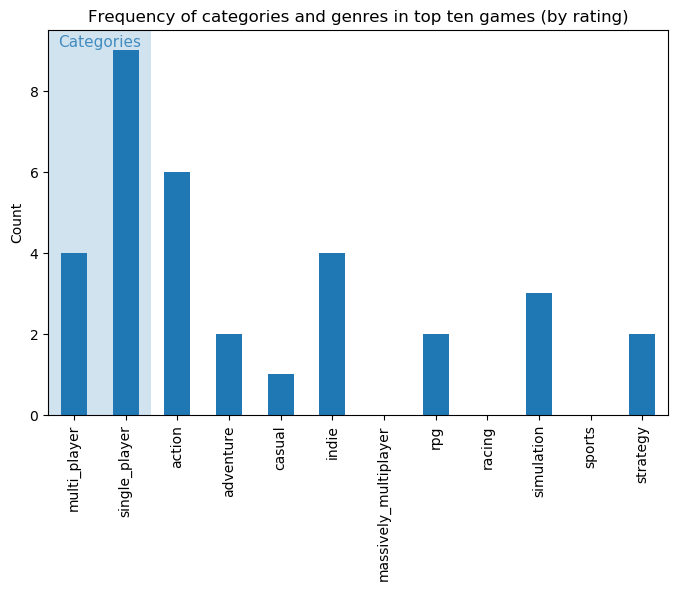

In [18]:
# df = data.drop(['required_age', 'positive_ratings', 'negative_ratings'], axis=1).copy()

display_cols = ['name', 'developer', 'publisher', 'release_year', 'genres', 'average_playtime', 'owners', 'rating', 'price']
top_ten = df.sort_values(by='rating', ascending=False).head(10)

display(top_ten[display_cols])

plt.rcdefaults()

gen_cols = df.columns[-13:-1]
ax = top_ten[gen_cols].sum().plot.bar(figsize=(8,5))

ax.fill_between([-.5, 1.5], 10, alpha=.2)
ax.text(0.5, 9.1, 'Categories', fontsize=11, color='tab:blue', alpha=.8, horizontalalignment='center')

ax.set_ylim([0, 9.5])
ax.set_ylabel('Count')
ax.set_title('Frequency of categories and genres in top ten games (by rating)')

plt.show()

- Lots of these by Valve, Steam originally a platform for their games
- Good mix of older and newer games
- All have over 1 million owners

- Almost all are single player games, and over half are action
- None are massively multiplayer, racing or sports
- Can't tell much from this small sample, but we'll keep this in mind for later on

So maybe there are genres that tend to be rated more highly?

Based on what we've seen so far, we'll be focusing on paid games with 20,000 or more owners.

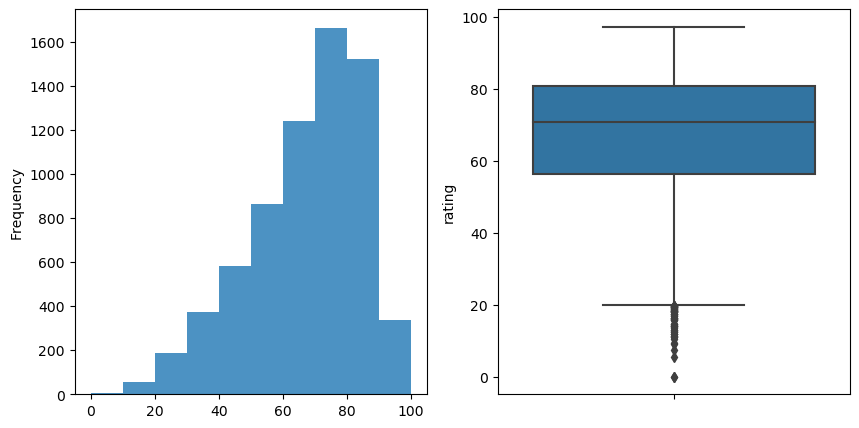

Mean rating: 67.21%


In [19]:
df = data[(data.owners >= 20000) & (data.price > 0)].copy()

fig, axarr = plt.subplots(1, 2, figsize=(10,5))

df.rating.plot.hist(range=(0, 100), bins=10, ax=axarr[0], alpha=.8)

# sns.distplot(df.rating, bins=range(0,100,10), ax=axarr[0])
ax = sns.boxplot(x='rating', data=df, orient='v', ax=axarr[1])
plt.show()

print(f'Mean rating: {df.rating.mean():.2f}%')

- Ratings are left-skewed. Most (50%) ratings in region 60-80.


# Done to here
go on to genres vs ratings

ANOVA (analysis of variance) test.  
null hypothesis: two or more groups have the same population mean

Assumptions:
- samples are independent
- each sample is from a normally distributed population
- population standard deviations of the groups are equal (homoscedasticity)

In [190]:
import scipy.stats as stats

f = stats.f_oneway(
    df[df['action'] == 1]['rating'],
    df[df['adventure'] == 1]['rating'],
    df[df['casual'] == 1]['rating'],
    df[df['indie'] == 1]['rating'],
    df[df['massively_multiplayer'] == 1]['rating'],
    df[df['rpg'] == 1]['rating'],
    df[df['racing'] == 1]['rating'],
    df[df['simulation'] == 1]['rating'],
    df[df['sports'] == 1]['rating'],
    df[df['strategy'] == 1]['rating']
)

f

F_onewayResult(statistic=7.892961152519917, pvalue=1.0139122478007528e-11)

- Very small p-value means we reject the null hypothesis
- We can conclude variance in ratings is affected by genre

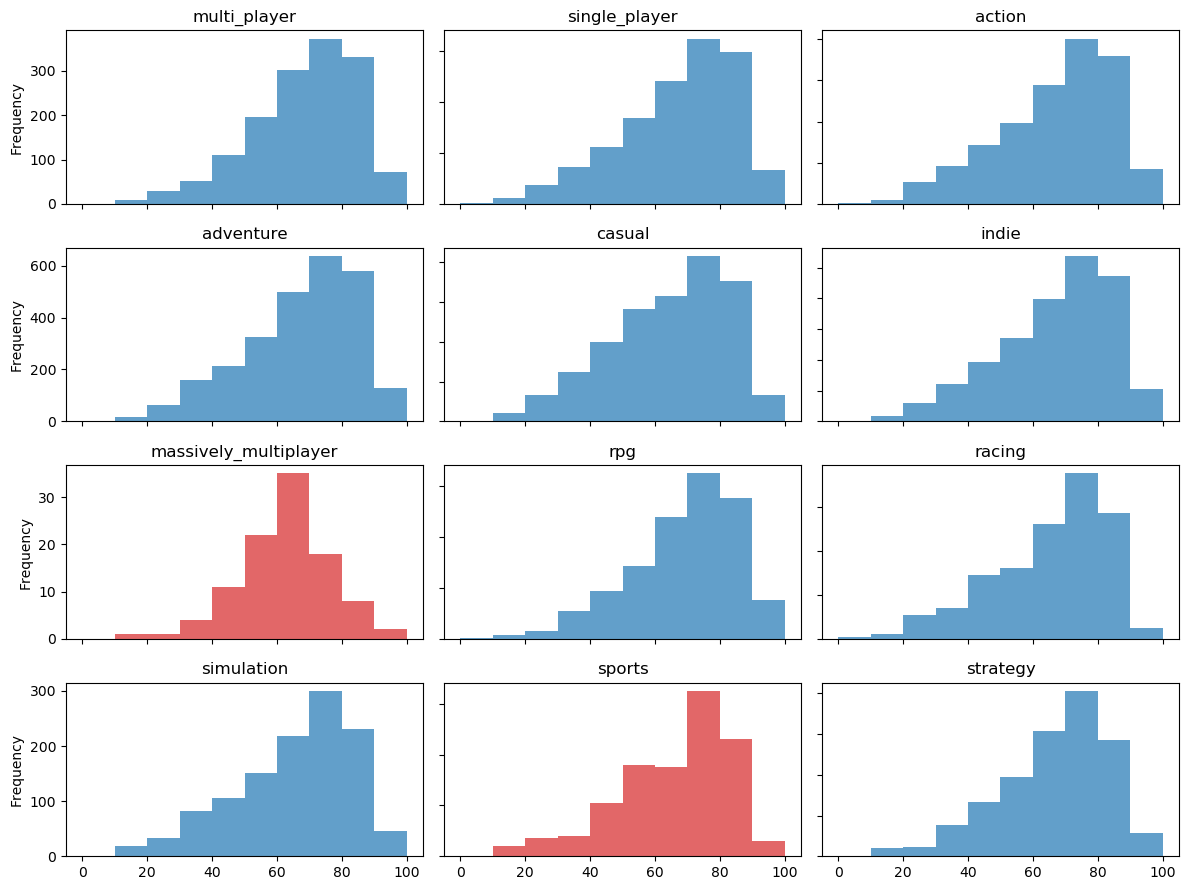

In [201]:
# (data[genre_cols].multiply(data['weighted_rating'], axis=0).sum() / data[genre_cols].sum()).plot.bar()

# ratings distribution by genre - need to create fig array
fig = plt.figure(figsize=(12, 9))

for i in range(12):
    ax = fig.add_subplot(4, 3, i+1)
    
    col = gen_cols[i]
    temp_df = df.loc[df[col] == 1, [col, 'rating']]
    
    if col in ['massively_multiplayer', 'sports']:
        color = 'tab:red'
    else:
        color = 'tab:blue'
    
    temp_df['rating'].plot.hist(ax=ax, sharey=True, sharex=True, range=(0,100), bins=10, color=color, alpha=.7)
    ax.set_title(col)

plt.tight_layout()
plt.show()

casual                   1000
strategy                 1000
rpg                      1000
single_player            1000
adventure                1000
simulation               1000
multi_player             1000
action                   1000
indie                    1000
racing                    278
sports                    228
massively_multiplayer     102
Name: genre, dtype: int64


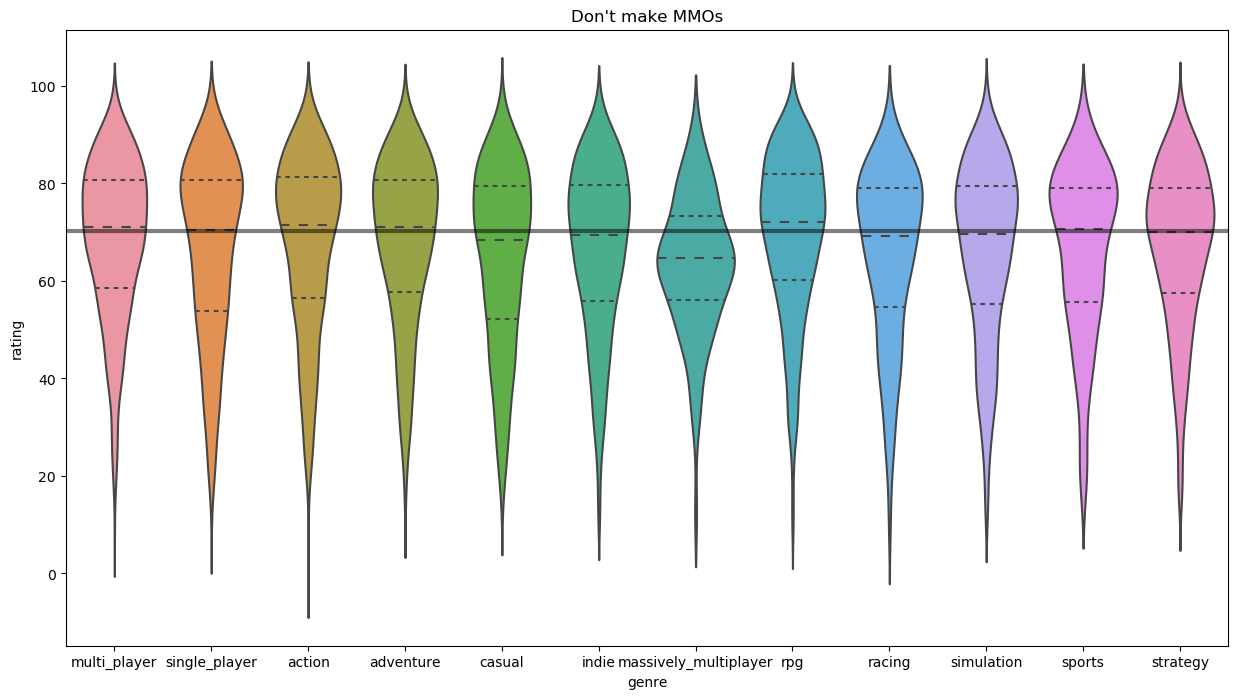

In [68]:
g_df = pd.DataFrame()

for col in gen_cols:
    # method 1
    # temp_df = df[df[col] == 1].copy()
    # temp_df['genre'] = col
    # g_df = pd.concat([g_df, temp_df], axis=0)
    
    # method 2
    # ratings = pd.DataFrame(df.loc[df[col] == 1, 'rating'].values, columns=['rating'])
    
    # method 3
    # ratings = pd.DataFrame(df.loc[df[col] == 1, 'rating'].sample(1000, random_state=1, replace=True).values, columns=['rating'])
    
    # method 4
    rating_df = df.loc[df[col] == 1, 'rating']
    sample_size = 1000
    
    if rating_df.shape[0] > sample_size:
        ratings = pd.DataFrame(rating_df.sample(sample_size, random_state=1).values, columns=['rating'])
    else:
        ratings = pd.DataFrame(rating_df.values, columns=['rating'])
    
    # for methods 2, 3, 4
    ratings['genre'] = col
    g_df = pd.concat([g_df, ratings], axis=0)
    
print(g_df['genre'].value_counts())
fig, ax = plt.subplots(figsize=(15,8))
# sns.stripplot(x='rating', y='genre', data=g_df, jitter=True, alpha=1, linewidth=1)
sns.violinplot(x='genre', y='rating', data=g_df, inner='quartile', ax=ax)
ax.axhline(g_df.rating.median(), color='black', lw=3, alpha=.5)

ax.set_title("Don't make MMOs");

Because of the overlap, there are only minor differences to rating based on genre. 
- MMO much lower than others, .
- Casual lower than most,
- Racing and simulation slightly lower
- RPG slightly better than most

In [72]:
g_df = pd.DataFrame()

for col in gen_cols:
    # method 1
    # temp_df = df[df[col] == 1].copy()
    # temp_df['genre'] = col
    # g_df = pd.concat([g_df, temp_df], axis=0)
    
    # method 2
    ratings = pd.DataFrame(df.loc[df[col] == 1, 'rating'].values, columns=['rating'])
    
    # method 3
    # ratings = pd.DataFrame(df.loc[df[col] == 1, 'rating'].sample(1000, random_state=1, replace=True).values, columns=['rating'])
    
    # method 4
    #rating_df = df.loc[df[col] == 1, 'rating']
    #sample_size = 1000
    
#     if rating_df.shape[0] > sample_size:
#         ratings = pd.DataFrame(rating_df.sample(sample_size, random_state=1).values, columns=['rating'])
#     else:
#         ratings = pd.DataFrame(rating_df.values, columns=['rating'])
    
    # for methods 2, 3, 4
    ratings['genre'] = col
    g_df = pd.concat([g_df, ratings], axis=0)
    
print(g_df['genre'].value_counts())
# fig, ax = plt.subplots(figsize=(15,8))
# sns.stripplot(x='rating', y='genre', data=g_df, jitter=True, alpha=1, linewidth=1)
# sns.violinplot(x='genre', y='rating', data=g_df, inner='quartile', ax=ax)
# ax.axhline(g_df.rating.median(), color='black', lw=3, alpha=.5)

# ax.set_title("Don't make MMOs");
grouped = g_df.groupby('genre')
grouped.apply(lambda x: x.sample(1000, random_state=1) if x.shape[0] > 1000 else x)

single_player            6650
indie                    4363
action                   3261
adventure                2622
casual                   1846
strategy                 1503
multi_player             1479
rpg                      1233
simulation               1186
racing                    278
sports                    228
massively_multiplayer     102
Name: genre, dtype: int64


rating     genre
genre                             
action   517   88.965075    action
         1070  40.724383    action
         93    58.584322    action
         1650  73.836406    action
         442   82.827536    action
         487   70.425670    action
         1080  68.431732    action
         3014  26.760702    action
         2608  38.026401    action
         1526  68.717501    action
         540   63.021518    action
         464   59.155474    action
         2368  53.286910    action
         2596  72.909321    action
         2526  50.008228    action
         2476  78.509643    action
         2963  77.539170    action
         2234  76.296923    action
         1194  78.680294    action
         3170  87.066876    action
         1716  72.722322    action
         2744  79.843536    action
         993   90.335713    action
         2015  83.923105    action
         2101  68.660930    action
         2117  36.232289    action
         3007  41.647735    action
         1749  66.551557    action
         3142  73.385357    action
         2687  36.405394    action
...                  ...       ...
strategy 684   50.497582  strategy
         1116  75.405192  strategy
         466   78.232873  strategy
         1377  81.459705  strategy
         1307  76.978846  strategy
         662   73.522151  strategy
         938   73.790705  strategy
         447   84.672357  strategy
         371   52.024902  strategy
         557   43.942043  strategy
         854   33.197953  strategy
         1055  77.124476  strategy
         271   81.754624  strategy
         605   60.962207  strategy
         449   80.433035  strategy
         1487  52.867770  strategy
         523   83.998409  strategy
         214   72.779510  strategy
         344   76.394099  strategy
         838   42.766429  strategy
         1425  69.976876  strategy
         147   47.112863  strategy
         1348  48.208497  strategy
         1128  91.246669  strategy
         723   72.473598  strategy
         412   87.666736  strategy
         688   79.869053  strategy
         1342  81.956503  strategy
         783   67.298625  strategy
         342   77.500507  strategy

[9608 rows x 2 columns]

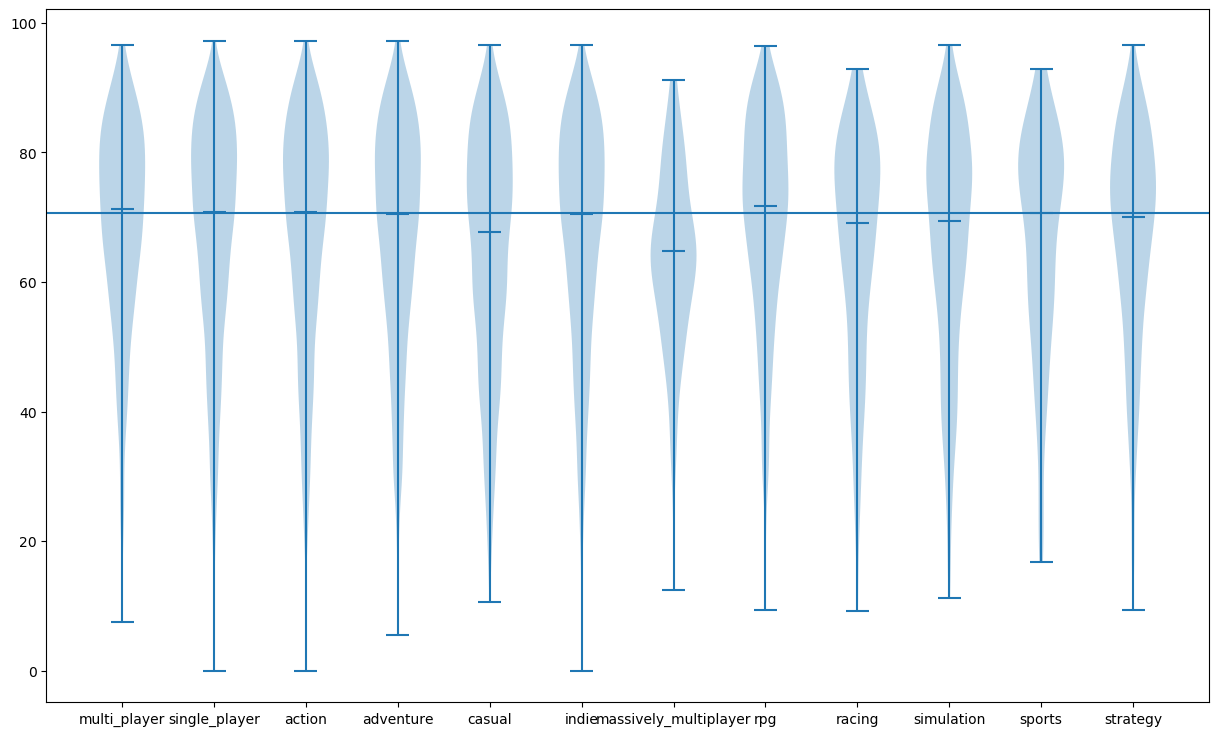

In [28]:
# ac = data.loc[data['action'] == 1, 'weighted_rating']
# ad = data.loc[data['adventure'] == 1, 'weighted_rating']

fig, ax = plt.subplots(figsize=(15,9))

temp_df = df.copy()
temp_df = temp_df[temp_df.owners >= 20000]

ax.violinplot([temp_df.loc[temp_df[g] == 1, 'rating'].values for g in gen_cols],
               showmeans=False,
               showmedians=True
              )

ax.axhline(temp_df['rating'].median())

ax.set_xticks(range(1,13))
ax.set_xticklabels(gen_cols, rotation=0)
# plt.xticks(ticks=[i for i in range(1, 11)], labels=[g for g in genre_cols]);

plt.show()

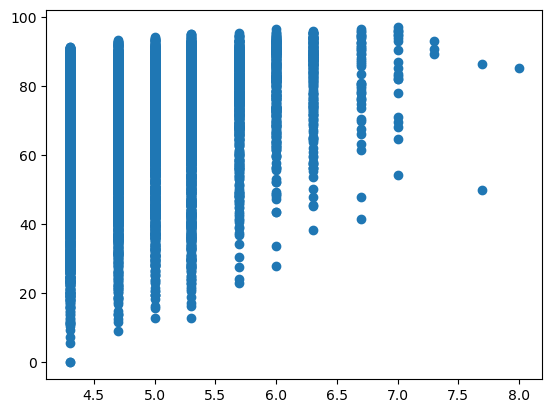

In [361]:
log_owners = np.log10(df.owners)
# as box/violin?
plt.scatter(log_owners, df['rating'])

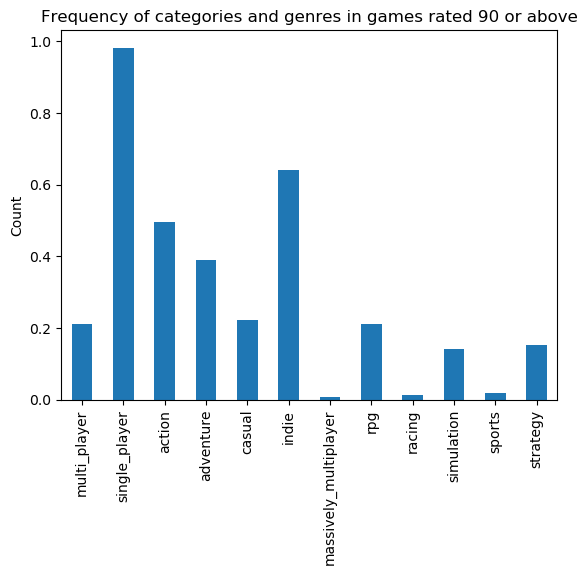

In [127]:
ax = by_rating[by_rating['rating'] >= 90].iloc[:, -12:].mean().plot.bar()

# ax.fill_between([-.5, 1.5], 410, alpha=.2)
# ax.text(0.5, 390, 'Categories', fontsize=11, color='tab:blue', alpha=.7, horizontalalignment='center')

total = by_rating[by_rating['rating'] >= 90].shape[0]
# ax.axhline(total, color='black', alpha=.4)
# ax.text(11.8, total-5, f'Total Games: {total}', alpha=.7)

# ax.set_ylim([0, 410])
ax.set_ylabel('Count')
ax.set_title('Frequency of categories and genres in games rated 90 or above')

plt.show()

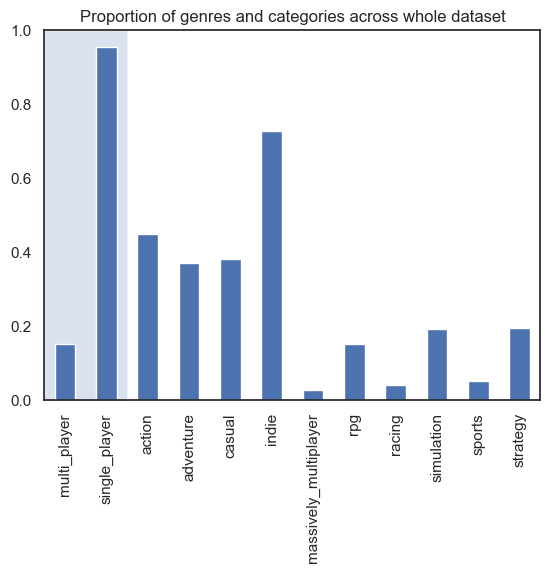

In [387]:
genre_cols = df.columns[-12:]
ax = df[genre_cols].mean().plot.bar()

ax.fill_between([-.5, 1.5], 1, alpha=.2)
ax.set_ylim([0, 1])
ax.set_title('Proportion of genres and categories across whole dataset')

plt.show()

- Most are action, indie, simulation. Must remember that games can belong to multiple genres
- Almost all are single player, a little under half are or have multiplayer

- Similar picture, like majority single-player
- action less pronounced, similar in frequency to adventure and casual
- indie by far the most frequent genre
- massively multiplayer, racing and sports the least frequent

In [ ]:
df_rating_bin = df.copy()

df_rating_bin['rating_bin'] = pd.cut(df_rating_bin['rating'], 
                                     bins=[0,20,40,60,80,100],#[0,25,40,60,75,90,100],
                                     labels=None)

# df_rating_bin.groupby('rating_bin').mean()[['owners']].plot.bar()
# df_rating_bin.groupby('rating_bin').mean()[['average_playtime']].plot.bar()

df['rating'].plot.kde()

In [364]:
# def plot_correlation_heatmap(df):
#     corr = df.corr()
    
#     sns.set(style='white')
#     mask = np.zeros_like(corr, dtype=np.bool)
#     mask[np.triu_indices_from(mask)] = True
    
#     f, ax = plt.subplots(figsize=(11,9))
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
#     sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
#                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
#     plt.show()
    
# plot_correlation_heatmap(by_rating.head(1000))

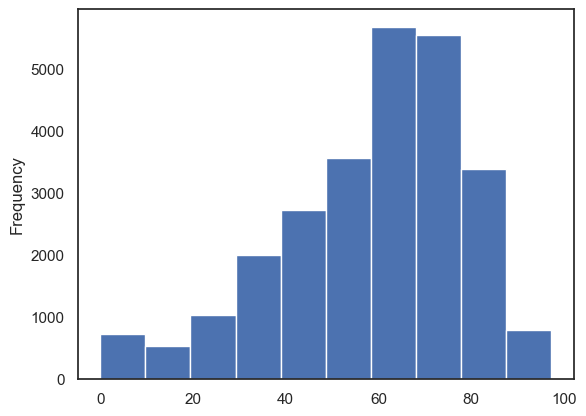

In [289]:
df['rating'].plot.hist()

# Free vs paid

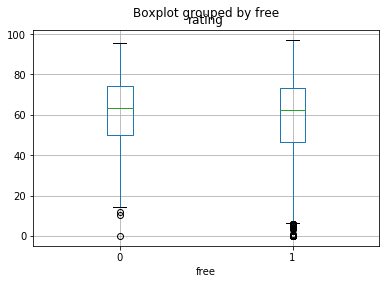

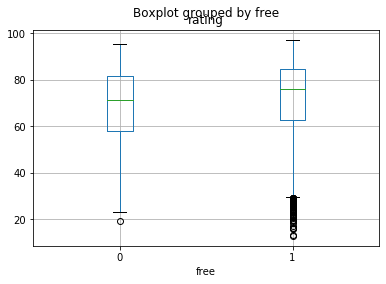

In [19]:
# free vs paid rating
df['free'] = 0
df.loc[df['price'] > 0, 'free'] = 1

df.boxplot(column='rating', by='free')
plt.show()
df[df['owners'] >= 100000].boxplot(column='rating', by='free')

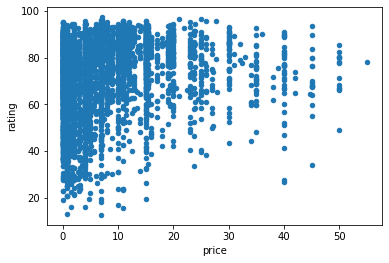

In [30]:
# price vs rating
df[(df['price'] < 100) & (df['owners'] >= 100000)].plot.scatter(x='price', y='rating')


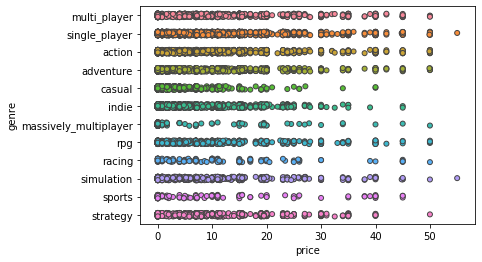

In [53]:
g_cols = df.columns[-13:-1]

g_df = pd.DataFrame()

for col in g_cols:
    temp_df = df[df[col] == 1].copy()
    temp_df['genre'] = col
    g_df = pd.concat([g_df, temp_df], axis=0)
    
g_df = g_df[(g_df['price'] < 100) & (g_df['owners'] >= 100000)]
sns.stripplot(x='price', y='genre', data=g_df, jitter=True, alpha=1, linewidth=1)

- Games are likely to come down in price over time. 
- Fortunately due to Steam's frequent sales, the listed price tends to remain close to the release price.
- Still, worth looking at recent releases only

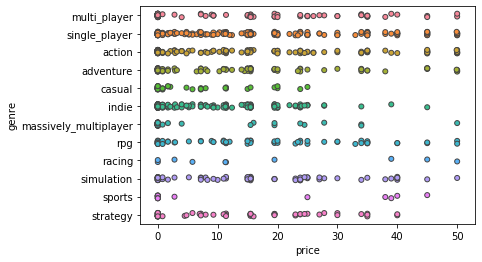

In [55]:
recent_df = g_df[g_df['release_year'] >= 2018].copy()
sns.stripplot(x='price', y='genre', data=recent_df, jitter=True, alpha=1, linewidth=1)

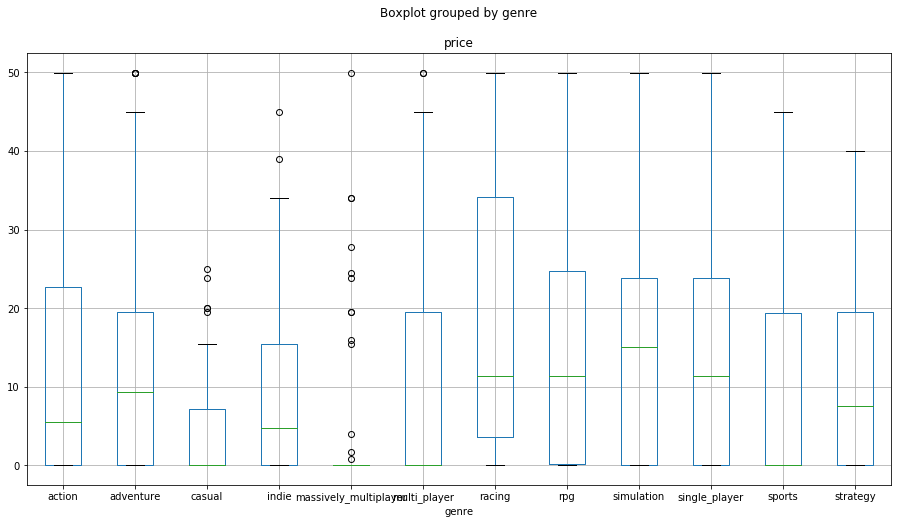

In [61]:
recent_df.boxplot(column='price', by='genre', figsize=(15,8))

## Correlations

8230


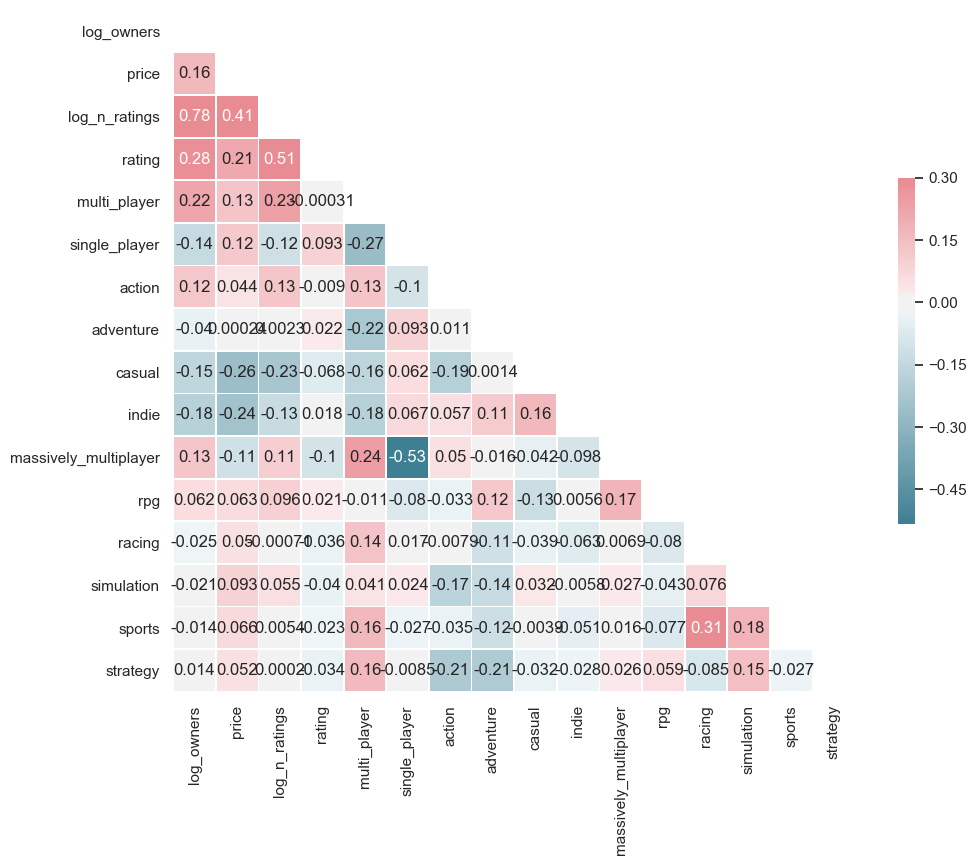

In [429]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(11,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.show()

    
genre_cols = df.columns[-12:]
temp_df = df[df['owners'] > 0].copy()
temp_df['log_owners'] = np.log10(temp_df['owners'])
temp_df['log_n_ratings'] = np.log10(temp_df['total_ratings'])
# temp_df = temp_df[df['owners'] >= 100000]



print(temp_df.shape[0])
plot_correlation_heatmap(temp_df[['genres', 'log_owners', 'price', 'log_n_ratings', 'rating'] + list(genre_cols)])

## Genres

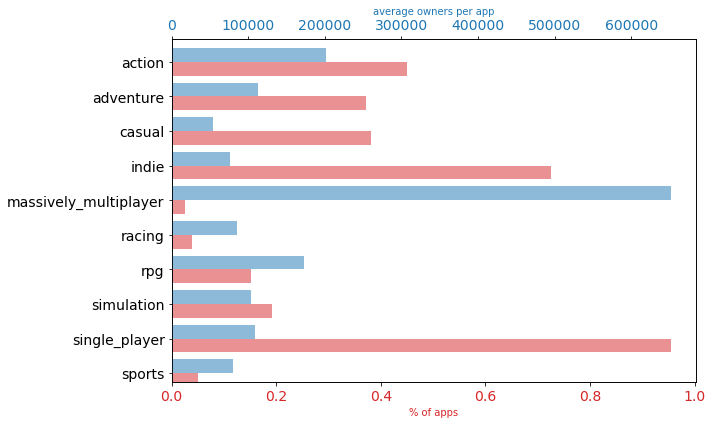

In [303]:
# percentage of apps in each genre
genre_cols = data.columns[-12:-2]

total_owners_per_genre = data[genre_cols].multiply(data['owners'], axis='index').sum()
average_owners_per_genre = total_owners_per_genre / data[genre_cols].sum()

fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:red'
data[genre_cols].mean().sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.5, position=1, fontsize=14, width=0.4)
# ax1.set_ylabel('genre')

ax1.set_xlabel('% of apps', color=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.tick_params(axis='y', left='off', top='off')
# ax1.axes.get_yaxis().set_visible(False)

ax2 = ax1.twiny()

color = 'tab:blue'
average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=.5, position=0, fontsize=14, width=0.4)
ax2.set_xlabel('average owners per app', color=color)
ax2.tick_params(axis='x', labelcolor=color)
ax2.axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

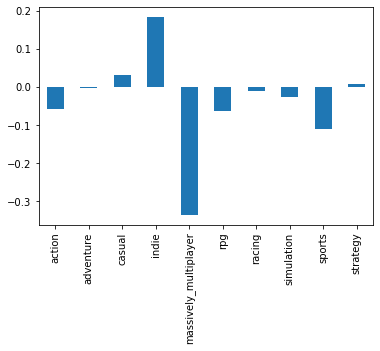

In [184]:
non_valve.head(1000).corr()['weighted_rating'][genre_cols].plot.bar()

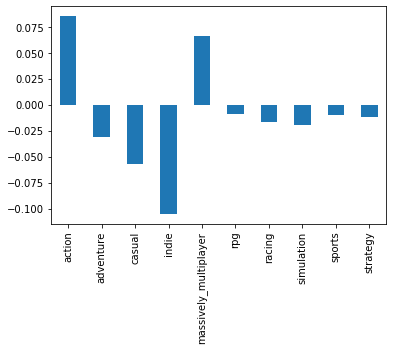

In [143]:
df.corr()['owners'][genre_cols].plot.bar()

## Developers and publishers

In [359]:
temp_df = df.copy()
temp_df['count'] = 1

pv = temp_df.pivot_table(index='developer', values=['rating', 'count', 'owners'],
                         aggfunc={'rating': np.mean, 'count': np.sum, 'owners': np.sum}).sort_values(by='owners', ascending=False)

display(pv.head())

top_devs = pv[pv['count'] >= 3].head()
top_devs

,count,owners,rating
developer,,,
Valve,24,265000000,86.229421
Valve;Hidden Path Entertainment,1,50000000,86.310312
PUBG Corporation,1,50000000,50.066901
Bethesda Game Studios,10,23700000,80.565951
Digital Extremes,3,21050000,83.445259


,count,owners,rating
developer,,,
Valve,24,265000000,86.229421
Bethesda Game Studios,10,23700000,80.565951
Digital Extremes,3,21050000,83.445259
Facepunch Studios,4,15000000,73.472961
Ubisoft Montreal,19,13300000,74.314250


In [373]:
# df[df['developer'].isin(top_devs.index)].sort_values(by='developer')[display_cols]

In [372]:
pv = temp_df.pivot_table(index='publisher', values=['rating', 'count', 'owners'],
                         aggfunc={'rating': np.mean, 'count': np.sum, 'owners': np.mean}).sort_values(by='owners', ascending=False)

top_pubs = pv[pv['count'] >= 10].head(5)
top_pubs

,count,owners,rating
publisher,,,
Valve,28,1.196429e+07,86.721731
Rockstar Games,15,1.613333e+06,77.653614
Bethesda Softworks,34,1.233824e+06,77.520152
Electronic Arts,32,7.975000e+05,77.736716
Tripwire Interactive,11,7.818182e+05,78.361962


In [374]:
# df[df['publisher'].isin(top_pubs.index)].sort_values(by='publisher')[display_cols]

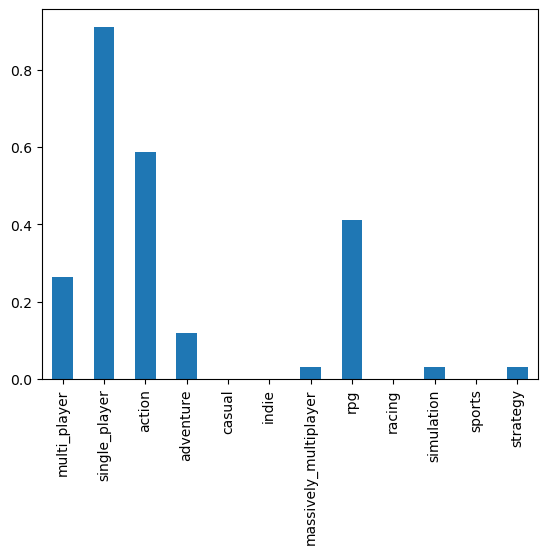

In [407]:
df[df['publisher'] == 'Bethesda Softworks'].iloc[:, -12:].mean().plot.bar()

In [489]:
top_rated = df[df['rating'] >= 90].copy()

top_rated['count'] = 1
top_pubs = top_rated.groupby('publisher').agg('sum').sort_values(by='count', ascending=False).head(10)
top_devs = top_rated.groupby('developer').agg('sum').sort_values(by='count', ascending=False).head(10)

top_pubs[['owners', 'count']]
temp_df = (top_pubs[genre_cols[2:]] / top_pubs[genre_cols[2:]].sum(axis=0))

temp_df
top_rated.groupby('publisher').sum().sort_values(by='count', ascending=False)[genre_cols[2:]].idxmax(axis=1).head(10)
# temp_df.idxmax(axis=1)

publisher
Valve                                        action
Devolver Digital                              indie
Sekai Project                                casual
Bethesda Softworks                              rpg
SEGA                                       strategy
Quiet River                                  casual
AGM PLAYISM                                   indie
Neko Climax Studios                          action
Spike Chunsoft Co., Ltd.                  adventure
LucasArts;Lucasfilm;Disney Interactive       action
dtype: object

In [444]:
top_devs[['owners', 'count']]

,owners,count
developer,,
Valve,102000000,12
NEKO WORKs,1750000,5
Relic Entertainment,5000000,4
Neko Climax Studios,270000,4
id Software,2600000,4
Quiet River,270000,4
Nihon Falcom,350000,3
Double Fine Productions,4200000,3
Fireproof Games,450000,3


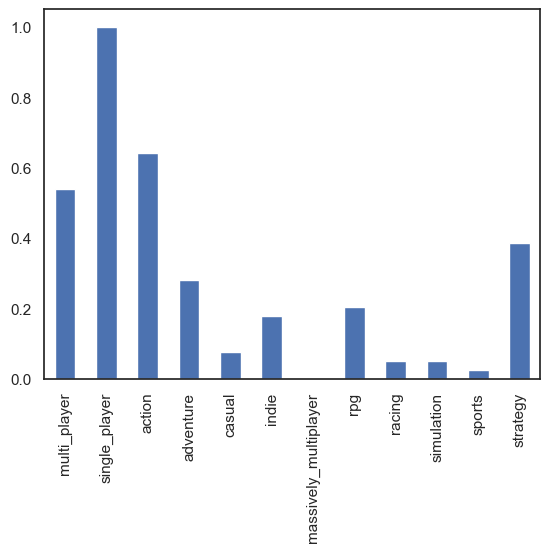

In [422]:
df[(df['publisher'] == 'SEGA') & (df['rating'] > 80)].mean()[genre_cols].plot.bar()

,n_releases,average_playtime,owners,weighted_rating
developer,,,,
Valve,24,2871.583333,403500000,86.229421
Bethesda Game Studios,10,2001.800000,37050000,80.565951
Digital Extremes,3,2012.000000,36575000,83.445259
Facepunch Studios,4,5443.500000,22520000,73.472961
Ubisoft Montreal,19,1027.368421,20270000,74.314250
Bohemia Interactive,15,2410.866667,19105000,60.984001
Gearbox Software,7,378.571429,17700000,77.642837
Rockstar North,4,2486.500000,16850000,72.952430
Relic Entertainment,8,556.625000,16500000,87.991890


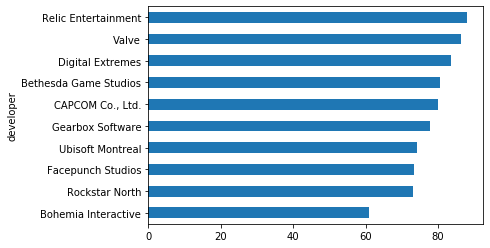

In [196]:
# top developers
dev_pv = data.pivot_table(index='developer', values=['appid', 'owners', 'average_playtime', 'weighted_rating'],
                 aggfunc={'appid': len, 
                          'owners': 'sum',
                          'average_playtime': 'mean',
                          'weighted_rating': 'mean'
                         }).rename({'appid': 'n_releases'}, axis=1).sort_values('owners', ascending=False)

top_devs_pv = dev_pv[dev_pv['n_releases'] > 1].head(10)

display(top_devs_pv)
top_devs_pv['weighted_rating'].sort_values().plot.barh();

,n_releases,average_playtime,owners,weighted_rating
publisher,,,,
Valve,28,3743.535714,508500000,86.721731
Ubisoft,111,956.459459,80835000,70.397394
Bethesda Softworks,34,1303.558824,66535000,77.520152
SEGA,78,766.012821,53245000,73.608514
Square Enix,96,1314.979167,48305000,69.041601
Electronic Arts,32,648.937500,41585000,77.736716
Paradox Interactive,55,925.218182,41265000,68.787463
Rockstar Games,15,980.333333,38360000,77.653614
2K,46,431.195652,33280000,62.705651


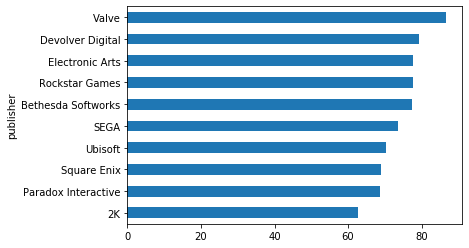

In [192]:
# top publishers
pub_pv = data.pivot_table(index='publisher', values=['appid', 'owners', 'average_playtime', 'weighted_rating'],
                         aggfunc={'appid': len, 
                                  'owners': 'sum',
                                  'average_playtime': 'mean',
                                  'weighted_rating': 'mean'
                         }).rename({'appid': 'n_releases'}, axis=1).sort_values('owners', ascending=False)

top_pubs_pv = pub_pv[pub_pv['n_releases'] > 1].head(10)

display(top_pubs_pv)
top_pubs_pv['weighted_rating'].sort_values().plot.barh();

,n_releases,average_playtime,owners,weighted_rating
publisher,,,,
Neko Climax Studios,4,77.500000,470000,91.008093
Matt Roszak,4,96.250000,585000,90.363814
Suspicious Developments,4,2000.750000,1925000,89.896718
Rusty Lake,4,175.250000,725000,89.611893
GirlGame,4,32.500000,535000,88.485926
Freebird Games,4,155.750000,2235000,88.202255
Scott Cawthon,8,2801.625000,5150000,87.676721
DrinkBox Studios,4,169.250000,1285000,87.595501
Annapurna Interactive,4,62.750000,585000,87.589290


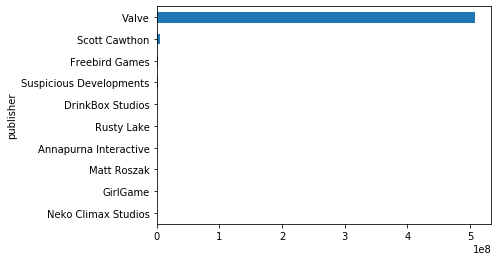

In [164]:
# top publishers
pub_pv = data.pivot_table(index='publisher', values=['appid', 'owners', 'average_playtime', 'weighted_rating'],
                         aggfunc={'appid': len, 
                                  'owners': 'sum',
                                  'average_playtime': 'mean',
                                  'weighted_rating': 'mean'
                         }).rename({'appid': 'n_releases'}, axis=1).sort_values('weighted_rating', ascending=False)

top_pubs_pv = pub_pv[pub_pv['n_releases'] > 3].head(10)

display(top_pubs_pv)
top_pubs_pv['owners'].sort_values().plot.barh();

## Ratings

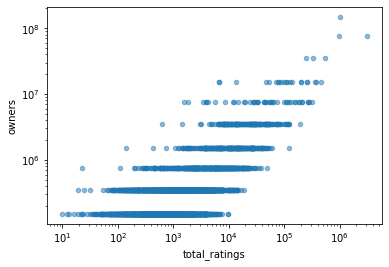

,owners,total_ratings
owners,1.000000,0.731956
total_ratings,0.731956,1.000000


In [249]:
df.plot.scatter(x='total_ratings', y='owners', alpha=0.5)

# x = df['total_ratings'].apply(math.log)
# y = df['owners'].apply(math.log)

x = df['total_ratings']
y = df['owners']


# calc the trendline (it is simply a linear fitting)
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# plt.plot(x, p(x))
# the line equation:
# print("y=%.6fx+(%.6f)" %(z[0],z[1]))

plt.xscale('log')
plt.yscale('log')
plt.show()

df[['owners', 'total_ratings']].corr()

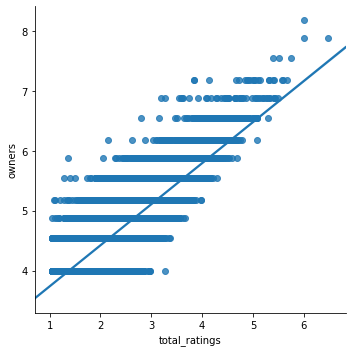

In [195]:
df_copy = data.copy()
df_copy = df_copy[df_copy['total_ratings'] > 10]
df_copy = df_copy[df_copy['owners'] > 0]

df_copy['total_ratings'] = np.log10(df_copy['total_ratings'])
df_copy['owners'] = np.log10(df_copy['owners'])

sns.lmplot("total_ratings", "owners", data=df_copy)

0.7133588514488597
58.74868722415526


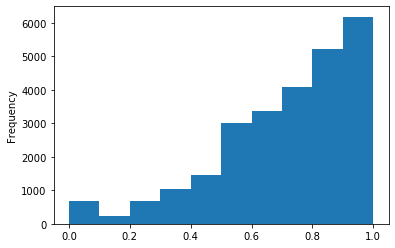

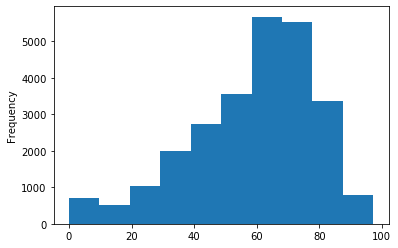

In [10]:
# overall ratings
print(data['rating'].mean())
print(data['weighted_rating'].mean())

data['rating'].plot.hist()
plt.show()

data['weighted_rating'].plot.hist();